In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load original data (27K rows × 5 columns)
input_path = "/content/drive/MyDrive/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv"
output_path = "Filtered_10K_Subset.csv"


df = pd.read_csv(input_path)


# Verify the new dataset
print(f"New shape: {df.shape}")  # Should be (10000, 5)
print("Columns preserved:", df.columns.tolist())

# Save to new CSV file
df.to_csv(output_path, index=False)
print(f"\n✅ Saved 10K subset to: {output_path}")

New shape: (26872, 5)
Columns preserved: ['flags', 'instruction', 'category', 'intent', 'response']

✅ Saved 10K subset to: Filtered_10K_Subset.csv


Step 1: EDA (Exploratory Data Analysis)

In [ ]:
print(f"Total samples: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nMissing values:")
print(df.isnull().sum())

Total samples: (26872, 5)
Columns: ['flags', 'instruction', 'category', 'intent', 'response']

Missing values:
flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64


Top 10 values in 'flags' column:
 flags
BL      5212
BLQ     2467
BIL     2138
BLM     1297
BILQ    1057
BLQZ     970
BLZ      902
BKL      862
BLMQ     600
BEL      533
Name: count, dtype: int64 

Top 10 values in 'category' column:
 category
ACCOUNT         5986
ORDER           3988
REFUND          2992
CONTACT         1999
INVOICE         1999
PAYMENT         1998
FEEDBACK        1997
DELIVERY        1994
SHIPPING        1970
SUBSCRIPTION     999
Name: count, dtype: int64 

Top 10 values in 'intent' column:
 intent
contact_customer_service    1000
complaint                   1000
check_invoice               1000
switch_account              1000
edit_account                1000
contact_human_agent          999
check_payment_methods        999
delivery_period              999
newsletter_subscription      999
get_invoice                  999
Name: count, dtype: int64 



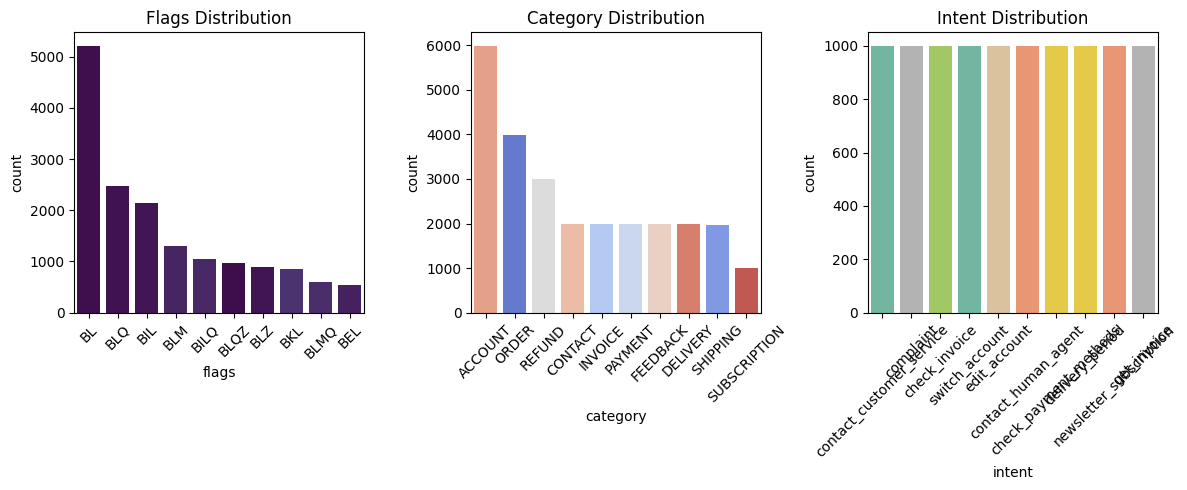

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



# Display only top 10 most frequent values
print("Top 10 values in 'flags' column:\n", df['flags'].value_counts().head(10), "\n")
print("Top 10 values in 'category' column:\n", df['category'].value_counts().head(10), "\n")
print("Top 10 values in 'intent' column:\n", df['intent'].value_counts().head(10), "\n")

# Set figure size
plt.figure(figsize=(12, 5))

# Plot for 'flags' column
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='flags', order=df['flags'].value_counts().index[:10], hue='flags', legend=False, palette="viridis")
plt.xticks(rotation=45)
plt.title("Flags Distribution")

# Plot for 'category' column
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='category', order=df['category'].value_counts().index[:10], hue='category', legend=False, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Category Distribution")

# Plot for 'intent' column
plt.subplot(1, 3, 3)
sns.countplot(data=df, x='intent', order=df['intent'].value_counts().index[:10], hue='intent', legend=False, palette="Set2")
plt.xticks(rotation=45)
plt.title("Intent Distribution")

# Show plots
plt.tight_layout()
plt.show()


Step 2: Preprocessing

Clean Text Columns

In [ ]:
import re

def clean_text(text):
    """
    Cleans the text by:
    1. Removing special characters (except basic punctuation).
    2. Normalizing whitespace.
    3. Converting text to lowercase.
    """
    text = re.sub(r"[^a-zA-Z0-9\s.,?!]", "", str(text))  # Keep letters, numbers, and punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    return text.lower()  # Convert to lowercase

# Apply cleaning function to the relevant columns
df["clean_instruction"] = df["instruction"].apply(clean_text)
df["clean_response"] = df["response"].apply(clean_text)

# Check the cleaned data
df[["instruction", "clean_instruction"]].head()


,instruction,clean_instruction
0,question about cancelling order {{Order Number}},question about cancelling order order number
1,i have a question about cancelling oorder {{Or...,i have a question about cancelling oorder orde...
2,i need help cancelling puchase {{Order Number}},i need help cancelling puchase order number
3,I need to cancel purchase {{Order Number}},i need to cancel purchase order number
4,"I cannot afford this order, cancel purchase {{...","i cannot afford this order, cancel purchase or..."


Step 3: Remove Stopwords

In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')  # Download stopwords (only needs to be done once)

stop_words = set(stopwords.words('english'))  # Load English stopwords

def remove_stopwords(text):
    """
    Removes stopwords from the text.
    """
    return " ".join([word for word in text.split() if word not in stop_words])

# Apply stopword removal (optional)
df["clean_instruction"] = df["clean_instruction"].apply(remove_stopwords)
df["clean_response"] = df["clean_response"].apply(remove_stopwords)

# Preview cleaned data
df[["instruction", "clean_instruction"]].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,instruction,clean_instruction
0,question about cancelling order {{Order Number}},question cancelling order order number
1,i have a question about cancelling oorder {{Or...,question cancelling oorder order number
2,i need help cancelling puchase {{Order Number}},need help cancelling puchase order number
3,I need to cancel purchase {{Order Number}},need cancel purchase order number
4,"I cannot afford this order, cancel purchase {{...","cannot afford order, cancel purchase order number"


Step 4: Handle Duplicates

In [ ]:
# Count initial rows
initial_count = len(df)

# Drop duplicate rows based on cleaned instruction and response
df = df.drop_duplicates(subset=["clean_instruction", "clean_response"])

# Print number of removed duplicates
print(f"Removed {initial_count - len(df)} duplicate rows")


Removed 1 duplicate rows


Step 5: Chunking (Sentence-Aware Splitting)

 Convert Data into LlamaIndex Document Format

In [ ]:
!pip install llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
from llama_index.core import Document
import json
import uuid

# Convert DataFrame into LlamaIndex Document format
documents = [
    Document(
        text=f"Q: {row['instruction']}\nA: {row['response']}",  # Concatenating the query and response
        metadata={"intent": row["intent"], "category": row["category"], "flags": row["flags"]}
    )
    for _, row in df.iterrows()
]

# Function to transform document to match the example structure
def document_to_dict(doc):
    return {
        "id_": str(uuid.uuid4()),  # Generate a unique ID for each document
        "metadata": doc.metadata,
        "text_resource": {
            "text": doc.text,
        },
        "text": doc.text
    }

# Save documents to a JSON file in the desired format
with open("documents_with_metadata.json", "w", encoding="utf-8") as f:
    json.dump([document_to_dict(doc) for doc in documents], f, ensure_ascii=False, indent=4)

print("Documents saved to documents_with_metadata.json")


Documents saved to documents_with_metadata.json


Chunking with SentenceSplitter

In [ ]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document

# Configure the chunking strategy
splitter = SentenceSplitter(
    chunk_size=256,  # Adjust based on model's context window (e.g., 4096 tokens for DeepSeek)
    chunk_overlap=20  # Keeps some context overlap between chunks
)

# Assuming 'documents' is already a list of Document objects
# Apply chunking to documents
nodes = splitter.get_nodes_from_documents(documents)

# Preview the first chunk of the first document
print(nodes[0].get_text())  # Print the first chunk of the first document

# Optionally, preview the first chunk from each document (if multiple documents are present)
for idx, node in enumerate(nodes[:5]):  # Display the first 5 chunks for example
    print(f"Chunk {idx+1}: {node.get_text()}")


Q: question about cancelling order {{Order Number}}
A: I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you.
Chunk 1: Q: question about cancelling order {{Order Number}}
A: I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you.
Chunk 2: Q: i have a question about cancelling oorder {{Order Number}}
A: I've been informed that you have a question about canceling order {{Order Number}}. I'm here to assist you! Please go ahead and let me know what specific question you have, and I'll provide you with all the information and guidance you need. Your satisfaction is my top priority.
Chunk 3: Q: i need help cancelling puchase {{Order Number}}
A: I can sense that you're seeking assist

Step 4: Embedding Preparation

In [ ]:
!pip install llama-index-embeddings-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import torch
import json

# Step 1: Initialize the HuggingFace embedding model
embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5",  # Choose your embedding model
    device="cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
)

# Step 2: Load the saved document JSON file
try:
    with open("documents_with_metadata.json", "r", encoding="utf-8") as f:
        documents = json.load(f)  # Load the documents with metadata
except FileNotFoundError:
    print("Error: documents_with_metadata.json not found. Make sure the file exists.")
    documents = []  # Prevent crash

# Step 3: Generate embeddings and store data
embedding_data = []  # Stores only embeddings + index + metadata
qa_data = []  # Stores QA + index separately

for idx, doc in enumerate(documents):
    # Extract QA text and metadata
    qa_text = doc.get("text", "")  # Full text containing QA
    metadata = doc.get("metadata", {})  # Metadata dictionary

    # Prepare metadata text
    metadata_text = f"Intent: {metadata.get('intent', '')}, " \
                    f"Category: {metadata.get('category', '')}, " \
                    f"Flags: {metadata.get('flags', '')}"

    full_text = f"{qa_text} | {metadata_text}"  # Combine QA and metadata

    # Generate embedding
    embedding = embed_model.get_text_embedding(full_text)

    # Store structured embedding data
    embedding_data.append({
        "index": idx,  # Index for retrieval
        "embedding": embedding,  # Embedding vector
        "metadata": metadata  # Metadata for filtering
    })

    # Store QA separately (question-answer text)
    qa_data.append({
        "index": idx,
        "QA": qa_text,
        "answer": metadata.get("answer", "")  # Ensure the answer is included (from metadata)
    })

# Step 4: Save embeddings to a structured JSON file
with open("chunked_embeddings.json", "w", encoding="utf-8") as f:
    json.dump(embedding_data, f, ensure_ascii=False, indent=4)

# Save QA dataset separately
with open("qa_dataset.json", "w", encoding="utf-8") as f:
    json.dump(qa_data, f, ensure_ascii=False, indent=4)

# Step 5: Print a preview of stored data
print("✅ Embeddings saved in chunked_embeddings.json")
print("✅ QA dataset saved in qa_dataset.json")
print(json.dumps(embedding_data[:2], indent=4))  # Print first 2 entries for verification


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embeddings saved in chunked_embeddings.json
✅ QA dataset saved in qa_dataset.json
[
    {
        "index": 0,
        "embedding": [
            -0.012685284949839115,
            -0.030016623437404633,
            0.0007164375856518745,
            0.004237413872033358,
            -0.049652099609375,
            0.019170090556144714,
            0.06551553308963776,
            -0.009984820149838924,
            0.004843189846724272,
            -0.013366236351430416,
            0.0253045205026865,
            0.011390730738639832,
            -0.018227780237793922,
            0.024143248796463013,
            -0.006517387926578522,
            0.025308217853307724,
            0.04456712678074837,
            -0.04106885939836502,
            -0.07570027559995651,
            -0.001236678916029632,
            0.008300445973873138,
            -0.012259082868695259,
            -0.045767463743686676,
            -0.004522331524640322,
            -0.013604598119854927,
         

 Initialize ChromaDB and Store Embeddings

In [ ]:
!pip install chromadb

In [ ]:
import os
import json
import hashlib
import numpy as np
from chromadb import PersistentClient

# Configuration
DB_PATH = "db_chroma"
EMBEDDINGS_FILE = "chunked_embeddings.json"
QA_FILE = "qa_dataset.json"

# Initialize ChromaDB
os.makedirs(DB_PATH, exist_ok=True)
client = PersistentClient(path=DB_PATH)
collection = client.get_or_create_collection("rag_documents")

def generate_id(index, qa_text):
    """Generate a unique ID using SHA-256 based on index and QA text."""
    key = f"{index}-{qa_text}"
    return hashlib.sha256(key.encode()).hexdigest()

# Load embedding data
with open(EMBEDDINGS_FILE, "r", encoding="utf-8") as f:
    embedding_data = json.load(f)

# Load QA dataset containing the full QA text
with open(QA_FILE, "r", encoding="utf-8") as f:
    qa_data = json.load(f)

# Build a dictionary mapping index to QA text
qa_dict = {entry["index"]: entry["QA"] for entry in qa_data}

# Insert each embedding individually into ChromaDB with the correct QA text
for entry in embedding_data:
    if "embedding" not in entry or len(entry["embedding"]) < 10:
        continue  # Skip invalid entries

    index = entry.get("index")
    # Retrieve QA text from qa_dict (fallback to placeholder if missing)
    doc_text = qa_dict.get(index, "No document text")

    # Generate a unique ID using the index and QA text
    unique_id = generate_id(index, doc_text)

    # Add the document to ChromaDB
    collection.add(
        ids=[unique_id],
        embeddings=[np.array(entry["embedding"], dtype=np.float32).tolist()],
        metadatas=[entry.get("metadata", {})],
        documents=[doc_text]
    )

print("✅ Data population complete!")


📌 Step 6: Query ChromaDB Without LLM

In [ ]:
!pip install --upgrade llama-index

In [ ]:
from llama_index.core import VectorStoreIndex, ServiceContext, Document
from chromadb import PersistentClient
import numpy as np
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import torch
import pprint

# Configuration
DB_PATH = "db_chroma"
QUERY = "What is the password reset procedure?"  # Example query

# Initialize ChromaDB client and collection
client = PersistentClient(path=DB_PATH)
collection = client.get_collection("rag_documents")

# Initialize the HuggingFace embedding model
embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5",  # Choose your embedding model
    device="cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
)

def query_chromadb_with_llamaindex(query):
    """Search ChromaDB using LlamaIndex and the query."""
    # Step 1: Generate the embedding for the query
    query_embedding = embed_model.get_text_embedding(query)

    # Step 2: Query ChromaDB for the closest documents
    results = collection.query(
        query_embeddings=[np.array(query_embedding, dtype=np.float32).tolist()],
        n_results=5  # Number of results to retrieve
    )

    # Print the structure of results to understand its format
    pprint.pprint(results)

    # Step 3: Process results
    if results and 'documents' in results:
        print("Query Results:")
        for i, document_list in enumerate(results['documents']):
            print(f"Result {i+1}:")
            for qa_text in document_list:
                print(f"QA Text: {qa_text}")

        if 'metadatas' in results:
            for i, metadata_list in enumerate(results['metadatas']):
                print(f"Metadata for Result {i+1}:")
                for metadata in metadata_list:
                    print(metadata)

            print("-" * 50)
    else:
        print("No results found for your query.")

# Run the query
query_chromadb_with_llamaindex(QUERY)


In [ ]:
!pip install transformers[deepseek]

In [ ]:
import os
import numpy as np
from chromadb import PersistentClient
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import torch
import pprint

# --- Official Memory Imports from LlamaIndex ---
from llama_index.core.memory import (
    VectorMemory,
    SimpleComposableMemory,
    ChatMemoryBuffer,
)
from llama_index.core.llms import ChatMessage

# --- Transformers imports for DeepSeek ---
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------
DB_PATH = "db_chroma"  # ChromaDB storage directory
QUERY = "What is the password reset procedure?"  # Example user query

# ------------------------------------------------------------------------------
# Initialize ChromaDB
# ------------------------------------------------------------------------------
client = PersistentClient(path=DB_PATH)
collection = client.get_collection("rag_documents")

# ------------------------------------------------------------------------------
# Initialize the Embedding Model for Retrieval
# ------------------------------------------------------------------------------
embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# ------------------------------------------------------------------------------
# Set Up Official Memory Components from LlamaIndex
# ------------------------------------------------------------------------------
# Secondary memory: vector memory using the embedding model.
vector_memory = VectorMemory.from_defaults(
    vector_store=None,
    embed_model=embed_model,
    retriever_kwargs={"similarity_top_k": 1},
)

# Optionally, set initial system messages.
initial_msgs = [
    ChatMessage.from_str("You are a helpful assistant.", "system"),
    ChatMessage.from_str("Welcome to the chatbot.", "system")
]
vector_memory.set(initial_msgs)

# Primary memory: a chat buffer that stores conversation history.
chat_memory_buffer = ChatMemoryBuffer.from_defaults()

# Compose memories.
composable_memory = SimpleComposableMemory.from_defaults(
    primary_memory=chat_memory_buffer,
    secondary_memory_sources=[vector_memory],
)

# ------------------------------------------------------------------------------
# Initialize DeepSeek Model for Response Generation
# ------------------------------------------------------------------------------
model_id = "deepseek-ai/deepseek-llm-7b-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
deepseek_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    offload_folder="./offload_folder"
)
# Load generation configuration and set pad_token_id to eos_token_id
deepseek_model.generation_config = GenerationConfig.from_pretrained(model_id)
deepseek_model.generation_config.pad_token_id = deepseek_model.generation_config.eos_token_id

# ------------------------------------------------------------------------------
# Function: Retrieve Documents from ChromaDB
# ------------------------------------------------------------------------------
def retrieve_documents(query, top_k=5):
    """
    Convert the query into an embedding and retrieve the top_k most relevant
    documents from the ChromaDB collection.
    """
    query_embedding = embed_model.get_text_embedding(query)
    results = collection.query(
        query_embeddings=[np.array(query_embedding, dtype=np.float32).tolist()],
        n_results=top_k
    )
    docs = []
    if results.get('documents'):
        for doc_list in results['documents']:
            for doc in doc_list:
                if doc:  # Only include non-empty document texts
                    docs.append(doc)
    return docs

# ------------------------------------------------------------------------------
# Function: Generate a Response using DeepSeek with Memory and Retrieval
# ------------------------------------------------------------------------------
def generate_response_with_memory(query):
    """
    Combines conversation history, retrieved documents, and the current query
    into a context string, then uses DeepSeek to generate a response.
    """
    # Add current user query to conversation memory.
    user_msg = ChatMessage.from_str(query, "user")
    chat_memory_buffer.put(user_msg)

    # Retrieve relevant documents.
    docs = retrieve_documents(query, top_k=5)
    docs_text = "\n".join(docs)  # Separate documents by newlines for clarity

    # Get conversation history and convert it to a string.
    conversation_history = chat_memory_buffer.get()
    conversation_history_str = "\n".join([str(msg) for msg in conversation_history])  # Convert list of ChatMessage to string

    # Build the full context with clear delimiters.
    full_context = (
        "Conversation History:\n" + conversation_history_str + "\n\n" +  # Use the converted string here
        "Retrieved Documents:\n" + docs_text + "\n\n" +
        "User Query:\n" + query + "\n\n" +
        "Assistant Response:"
    )

    # ... (rest of the function remains the same) ...
    # Tokenize the full context with attention mask.
    inputs = tokenizer(
        full_context,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    inputs = {k: v.to(deepseek_model.device) for k, v in inputs.items()}

    # Generate response with explicit attention mask.
    outputs = deepseek_model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=150,
        pad_token_id=deepseek_model.generation_config.pad_token_id
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Add assistant's response to conversation memory.
    assistant_msg = ChatMessage.from_str(response, "assistant")
    chat_memory_buffer.put(assistant_msg)

    return response

# ------------------------------------------------------------------------------
# Main Chatbot Function
# ------------------------------------------------------------------------------
def chatbot(query):
    """
    The chatbot function retrieves relevant documents, updates conversation
    memory, and generates a response using DeepSeek that is informed by both
    memory and retrieved documents.
    """
    response = generate_response_with_memory(query)
    return response

# ------------------------------------------------------------------------------
# Example Usage
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    response = chatbot(QUERY)
    print("Chatbot Response:", response)


tokenizer_config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Chatbot Response: Conversation History:
user: What is the password reset procedure?

Retrieved Documents:
Q: want help to reset my user pass
A: I'll take care of it! I'm here to lend you a helping hand to reset your user password. Let's work together to get you back on track! 

To initiate the password reset process, please follow these steps:

1. Visit our platform's "{{Password Reset Page}}" where you can start the procedure.
2. Look for the option that says "{{Reset Password}}" and click on it to proceed.
3. Next, provide the necessary details like your registered email address or username as requested.
4. Once you've entered the required information, keep an eye on your email inbox. You should receive an email shortly containing a link or instructions to reset your password. Remember to also check your spam or junk folders, just in case it lands there.
5. Follow the instructions provided in the email to create a new, secure password for your user account.

If you encounter any issu

In [ ]:
!zip -r db_chroma.zip db_chroma/

  adding: db_chroma/ (stored 0%)
  adding: db_chroma/cd450bf9-e32f-4694-9dd5-edaae88603ab/ (stored 0%)
  adding: db_chroma/cd450bf9-e32f-4694-9dd5-edaae88603ab/link_lists.bin (deflated 82%)
  adding: db_chroma/cd450bf9-e32f-4694-9dd5-edaae88603ab/length.bin (deflated 59%)
  adding: db_chroma/cd450bf9-e32f-4694-9dd5-edaae88603ab/data_level0.bin (deflated 12%)
  adding: db_chroma/cd450bf9-e32f-4694-9dd5-edaae88603ab/header.bin (deflated 54%)
  adding: db_chroma/cd450bf9-e32f-4694-9dd5-edaae88603ab/index_metadata.pickle (deflated 43%)
  adding: db_chroma/chroma.sqlite3 (deflated 62%)
